In [1]:
import os
os.chdir('../../code')

In [2]:
from model import get_model
import torch
from predict import *
from glob import glob
import matplotlib.pyplot as plt
from data.functional import collate_mask_fn
import numpy as np
from utils.metrics import cal_mAP
import torch.nn.functional as F

In [3]:
filelist = []

for root, dirs, files in os.walk('../params/effunet_b4'):
    for file in files:
        #append the file name to the list
        filelist.append(os.path.join(root,file))
print('\n'.join(filelist))

../params/effunet_b4/f00_exp_mish/ckpt/last.ckpt
../params/effunet_b4/f00_exp_mish/ckpt/epoch=77-precision=0.8416.ckpt
../params/effunet_b4/f00_exp_sgd_1/ckpt/epoch=71-precision=0.8525.ckpt
../params/effunet_b4/f00_exp_sgd_1/ckpt/last.ckpt
../params/effunet_b4/f00_exp_sgd_1/ckpt/last (copy).ckpt
../params/effunet_b4/f00_exp_spaattn/ckpt/last.ckpt
../params/effunet_b4/f00_exp_spaattn/ckpt/epoch=13-precision=0.8286.ckpt
../params/effunet_b4/f00_exp_spaattn_3/ckpt/last.ckpt
../params/effunet_b4/f00_exp_spaattn_3/ckpt/epoch=4-precision=0.7970.ckpt


In [4]:
pretrain = torch.load('../params/effunet_b4/f00_exp_spaattn_3/ckpt/last.ckpt')
state_dict = {k[5:]:v for k,v in pretrain['state_dict'].items()}

In [5]:
model = get_model('effunet_b4')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [6]:
root_ds = '../dataset'
cross_validation = True
fold_val_idx = 0

# DataFrame chứa toàn bộ train_id và đã được chia fold
df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
total_sample = len(df.index)
print('Total numper of sample:', total_sample)

val_df = df.loc[df.fold == 0].reset_index()
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment_strategy=0)) # Không augmentation cho valid set
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

Total numper of sample: 4000


In [7]:
val_iter = iter(val_dl)

In [14]:
batch = next(val_iter)

In [15]:
model.eval()
model.cuda()
with torch.no_grad():
    e1, e2, e3, e4, e5 = model.encoder(batch[0].cuda())
    c = model.center(e5)
    d5, d4, d3, d2, d1 = model.decoder(c, e5, e4, e3, e2)
    f = torch.cat((d1,
                   F.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=True),
                   F.interpolate(d3, scale_factor=4, mode='bilinear', align_corners=True),
                   F.interpolate(d4, scale_factor=8, mode='bilinear', align_corners=True),
                   F.interpolate(d5, scale_factor=16, mode='bilinear', align_corners=True)), 1)  # 320, 128, 128
    f = F.dropout2d(f, p=0.4)
    logits = model.logit(f)  # 1, 128, 128

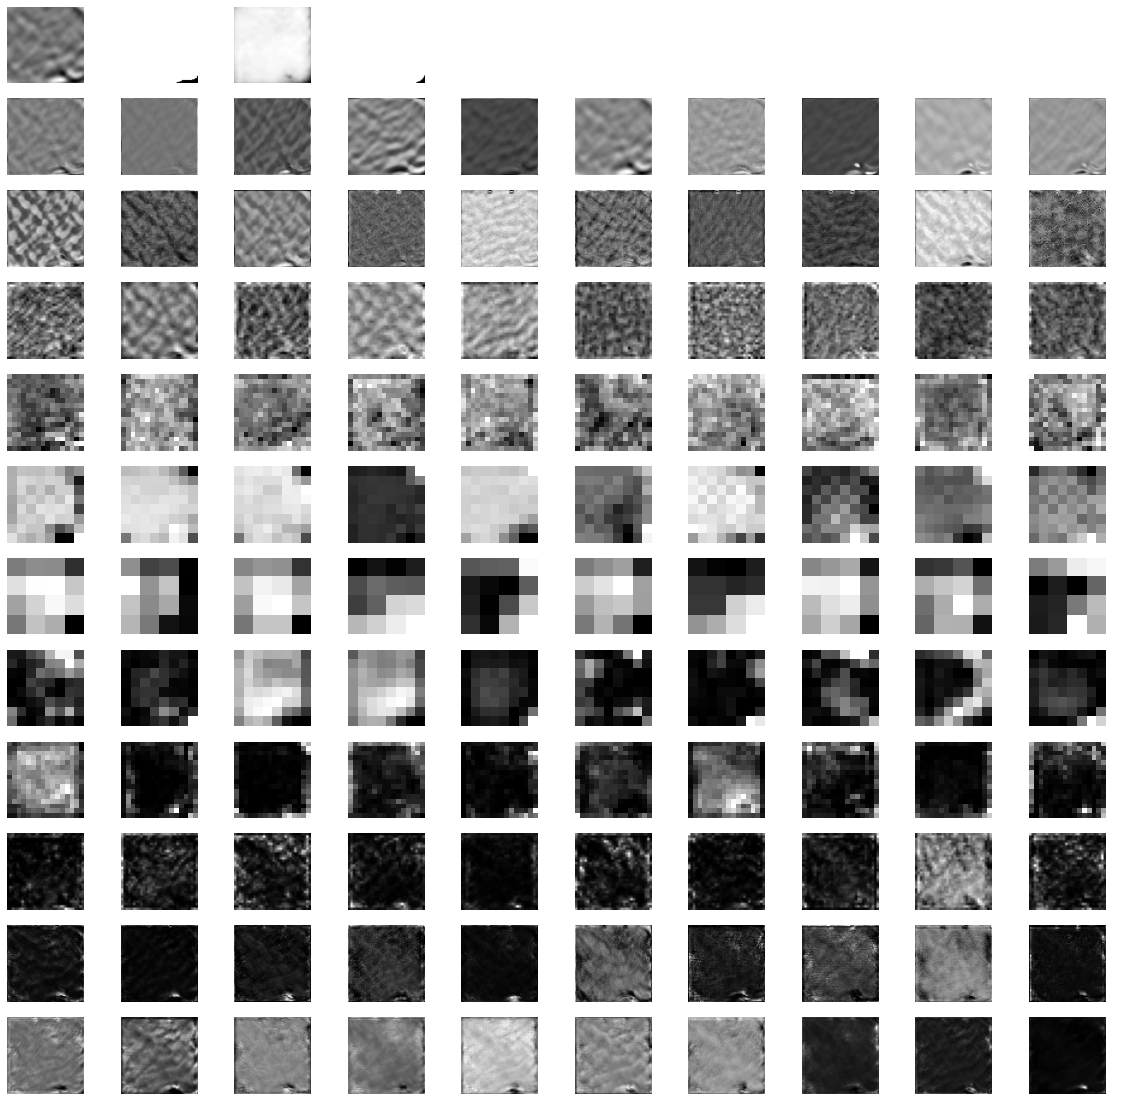

In [16]:
idx = 10
img = batch[0][idx]
mask = batch[1][idx]
_img = img.squeeze(0)
_msk = mask.squeeze(0).round()
inside = [fm[idx] for fm in [e1, e2, e3, e4, e5, c, d5, d4, d3, d2, d1]]
fig, axs = plt.subplots(nrows=len(inside) + 1, ncols=10, figsize=(20, 20))
axs[0, 0].imshow(_img, cmap='gray')
axs[0, 1].imshow(_msk, cmap='gray')
axs[0, 2].imshow((torch.sigmoid(logits[idx][0])).cpu(), cmap='gray')
axs[0, 3].imshow((torch.sigmoid(logits[idx][0]) > 0.5).cpu(), cmap='gray')


for ax in axs.flat:
    ax.axis('off')

for i, fm in enumerate(inside):
    for j in range(10):
        _att = fm[j].squeeze().cpu().numpy()
        axs[i + 1, j].imshow(_att, cmap='gray')
plt.show()

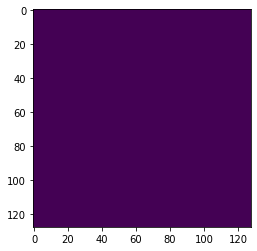

In [64]:
plt.imshow((torch.sigmoid(logits[idx][0]) > 0.5).cpu())

In [22]:
fig.savefig('inside_att_3_10.png')